# Guided Data Challenge Part III: Variational Posterior Inference

Author:
 - [@EiffL](https://github.com/EiffL) (Fancois Lanusse)
 
## Overview

In this last notebook, we will use everything we have seen so far, and try to perform posterior using Variational Inference.


### Learning objectives:

In this notebook we will put into practice:
  - Perform MAP inference 
  - Variational inference

In [38]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


## Step I: Load your generative model


Here I'm going to load an existing pretrained model, you should feel free to replace this by a model you might have  trained yourself :-)

In [39]:
# Let's start with the imports
import haiku as hk     # NN library
import optax           # Optimizer library
import pickle

# Utility function for tensoboard
from flax.metrics import tensorboard

# TensorFlow probability
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Specific models built by EiffL
from quarks2cosmos.models.vae import Decoder
from quarks2cosmos.models.flow import AffineFlow

In [5]:
# Create a random sequence
rng_seq = hk.PRNGSequence(42)

In [35]:
# Restore model parameters 
import pickle
with open('/ocean/projects/cis210053p/shared/deep_inverse/models/resvae2/model-50000.pckl', 'rb') as file:
    params, state, _ = pickle.load(file)
with open('/ocean/projects/cis210053p/shared/deep_inverse/models/flowResnet2/model-20000.pckl', 'rb') as file:
    params_flow, _ = pickle.load(file)    
    
params = hk.data_structures.merge(params, params_flow)

#### Create a forward model combining latent flow with VAE

In [40]:
def generative_model_fn(z):
    # Transform from Gaussian space to VAE latent space
    z1 = AffineFlow()().bijector.forward(z)
    
    # Decode sample with decoder
    likelihood = Decoder()(z1, is_training=False)
    
    return likelihood.mean()

generative_model = hk.without_apply_rng(hk.transform_with_state(generative_model_fn))

In [47]:
# To sample from the model, we draw from a Gaussian...
z = tfd.MultivariateNormalDiag(jnp.zeros(32), scale_identity_multiplier=1).sample(16, seed=next(rng_seq))
# And we run it through the forward model
x, _ = generative_model.apply(params, state, z)

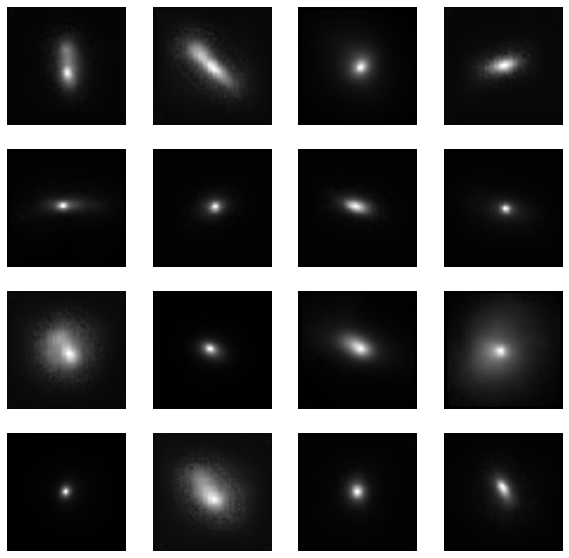

In [48]:
figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+4*j+1)
        imshow(x[i+4*j],cmap='gray')
        axis('off')

Not too bad :-)

## Step II: Back to our inverse problems

In [51]:
import quarks2cosmos.datasets
import tensorflow_datasets as tfds
from quarks2cosmos import galjax as gj

In [61]:
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN) # Load the TRAIN split
dset_cosmos = dset_cosmos.as_numpy_iterator()                  # Convert the dataset to numpy iterator

dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.as_numpy_iterator()

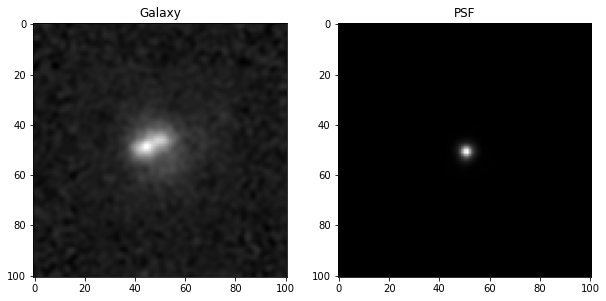

In [62]:
# Extract a new example from the dataset
cosmos = next(dset_cosmos)

figure(figsize=[10,5])
subplot(121)
imshow(cosmos['image'],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'],cmap='gray')
title('PSF');

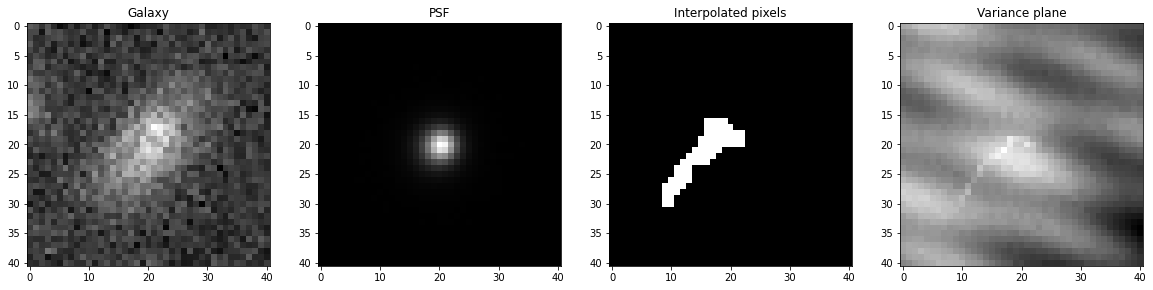

In [63]:
# Extract a new example from the dataset
hsc = next(dset_hsc)

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'],cmap='gray')
title('Variance plane');

In [53]:
def simulate_hsc(x, in_psf, out_psf):
    """ This function will simulate an image at HSC resolution given an image at HST resolution,
    accounting for input PSF and convolving by output PSF
    Args:
        x: HST resolution image (MUST BE ODD SIZE!!!!)
        in_psf: HST PSF
        out_psf: HSC PSF
    Returns:
        y: HSC simulated image of size [41,41]
    """
    y = gj.deconvolve(x, in_psf)         # Deconvolve by input PSF
    y = gj.kresample(y, 0.03, 0.168, 41) # Resample image to HSC grid
    y = gj.convolve(y,  out_psf)         # Reconvolve by HSC PSF
    return 2.587*y                       # Conversion factor for the flux

In [56]:
likelihood = tfd.Independent(tfd.Normal(loc=simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf']),
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) # This is to make sure TFP understand we have a 2d image

In [58]:
im_noise = likelihood.sample(seed=jax.random.PRNGKey(1))
x_true = cosmos['image']
cr_mask = 1.*(hsc['mask'] == 44)
y_obs = im_noise * (1 - cr_mask)

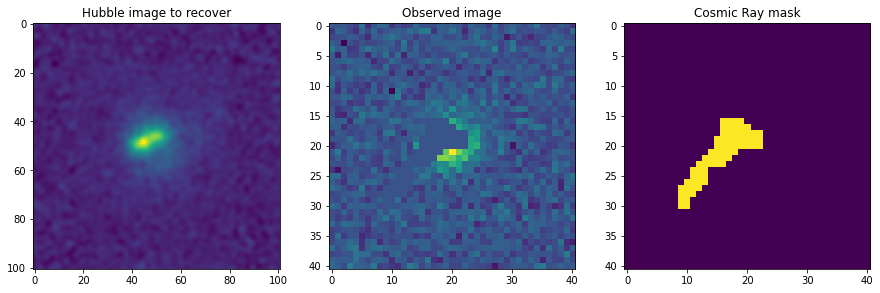

In [60]:
figure(figsize=[15,5])
subplot(131)
imshow(x_true)
title('Hubble image to recover')
subplot(132)
imshow(y_obs)
title('Observed image')
subplot(133)
imshow(cr_mask)
title('Cosmic Ray mask');

## Step III: MAP Inference

We now have all the tools for trying to perform Maximum A Posterior inference for our inverse problem, i.e.:

$$\hat{z} = \arg \max_{z} \log p(y | z) + \log p(z) $$

In order to achieve this, you will need to put together the following elements:

- Combine the physical forward model with generative model for an end-to-end forward model going from latent variable $z$ to HSC image.
- Write a function that computes the log posterior for a given $z$
- Use the tools from day I to do the optmization and recover a solution

Your turn :-)

## Step IV: Variational Inference

In the previous section, we only recover a single point estimate of the solution, but ideally we want to access the full posterior. In this section, we will try to use VI.


The idea of VI, is to use a parametric model $q_\theta$ to approximate the posterior distribution $p(z | x)$. You need two things:
- a tractable and flexible parametric model $q_\theta$, we can use a Normalizing Flow for instance ;-)
- a loss function that minimizes the distance between $p$ and $q_\theta$


The loss function typically used for VI is the Evidence Lower-Bound (ELBO) (the same one as we used in the VAE ;-) ). The ELBO is the right hand side part of this expression:

$$ p_\theta(y) \geq \mathbb{E}_{z \sim q_\theta}\left[ p(y | z) \right] - KL(q_\theta || p) $$
where $p$ in the KL divergence term is the latent space prior.

In other words, maximizing the ELBO tries to maximize the likelihood of the data under the model. 


In [64]:
# We are going to need a normalizing flow to model the posterior then
def sample_and_logp(N=1):
    flow = AffineFlow()()
    z = flow.sample(N, seed=hk.next_rng_key())
    log_p = flow.log_prob(z)
    return z, log_p

In [66]:
q_sample_logp = hk.transform(sample_and_logp)

# We initialize the parameters for the variational distribution
q_params = q_sample_logp.init(next(rng_seq), 1)

# And here is our prior distribution
p = tfd.MultivariateNormalDiag(jnp.zeros(32), 
                               scale_identity_multiplier=1.)

In [ ]:
# Let's write a concrete ELBO
def elbo(params, rng_key):
    
    # Sample from the log posterior
    z, log_q = q_sample_logp.apply(params, rng_key, N=100)
    
    # KL term 
    kl = log_q - p.log_prob(z)
    
    # You need to plug your forward model producing a likelihood object here
    likelihood = # .....
    
    log_likelihood.log_prob(y_obs)
    
    # Form the ELBO
    elbo = jnp.mean(log_likelihood - kl)
    
    return -elbo

The rest is now up to you :-) Use this ELBO to optimize the parameters of the posterior variational distribution $q_\theta$. Once you have achieved a good solution, try to sample from that posterior.